In [1]:
library(dplyr)
library(ggplot2)


ZOTU_phylum <- read.csv("phylum_ZOTUs.csv")

relative_abundance_all <- read.csv("relative_abundance_with_age.csv")
relative_abundance_with_age <- relative_abundance_all %>% select(-Melatonin_pg_g_Stool)
relative_abundance <- relative_abundance_with_age %>% select(-age_group)
relative_abundance_corr <- relative_abundance %>% select(-Sample_Code_16s)

Ages <- c('all' , '3 months', '6 months', '12 months')
Age <- Ages[4]     #'all' , '3 months', '6 months';, '12 months'

max_top_zotus <- 1000
all_zotus<- dim(relative_abundance)[2]
#defaults
zotu_pos <-0
zotu_neg <-0
all_samples <- dim(relative_abundance)[1]


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Calculate mean abundance for each OTU across all samples
mean_abundance <- colMeans(relative_abundance_corr)

# Sort OTUs by mean abundance in descending order and select the top 50 OTUs
top_otus <- sort(mean_abundance, decreasing = TRUE)[1:max_top_zotus]



In [3]:
relative_abundance_new <- relative_abundance_all[, c("Sample_Code_16s", "age_group", "Melatonin_pg_g_Stool")]
# Subset the original data to only include the top 50 OTUs
top_otu_data <- relative_abundance_corr %>%
  select(names(top_otus))

In [4]:
relative_abundance_new <- cbind(relative_abundance_new, top_otu_data)


In [5]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# Assuming relative_abundance_with_age and ZOTU_phylum are your data frames

# Melt the relative abundance data into a long format for easier analysis
relative_long <- relative_abundance_new %>%
  pivot_longer(cols = starts_with("ZOTU"), names_to = "OTU_ID", values_to = "Abundance")

# Merge with ZOTU_phylum to get the phylum information
merged_data <- merge(relative_long, ZOTU_phylum, by = "OTU_ID")

# Group by age group and phylum, then summarize the ZOTU counts per phylum
phylum_summary_by_age <- merged_data %>%
  group_by(age_group, Phylum) %>%
  summarise(Total_Abundance = sum(Abundance)) %>%
  mutate(Percent = (Total_Abundance / sum(Total_Abundance)) * 100)

# Select the top 4 most common phyla per age group and group the rest into "Other"
top_phyla_by_age <- phylum_summary_by_age %>%
  group_by(age_group) %>%
  arrange(desc(Total_Abundance)) %>%
  slice(1:4)

# Combine the rest into "Other" for each age group
other_phyla_by_age <- phylum_summary_by_age %>%
  group_by(age_group) %>%
  arrange(desc(Total_Abundance)) %>%
  slice(5:n()) %>%
  summarise(Phylum = "Other", Total_Abundance = sum(Total_Abundance), Percent = sum(Percent))

# Combine top phyla and "Other"
final_phylum_summary_by_age <- bind_rows(top_phyla_by_age, other_phyla_by_age)

# Plot the percentage of ZOTUs in each phylum by age group and add percentage labels
ggplot(final_phylum_summary_by_age, aes(x = reorder(Phylum, -Percent), y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = sprintf("%.1f%%", Percent)), vjust = -0.5, size = 3) +  # Add percentage labels
  facet_wrap(~age_group, scales = "free_y") +  # Create separate plots for each age group
  coord_flip() +  # Flip the coordinates for better readability
  labs(title = "Percentage of ZOTUs in Each Phylum by Age Group",
       x = "Phylum",
       y = "Percentage of ZOTUs") +
  theme_minimal() +
  theme(legend.position = "none")


`summarise()` has grouped output by 'age_group'. You can override using the `.groups` argument.


In [6]:
# Extract the ZOTU columns (assuming columns start with "ZOTU")
zotu_columns <- grep("^ZOTU", colnames(relative_abundance_new), value = TRUE)

# Create a function to calculate correlation for each ZOTU with Melatonin
correlation_results <- lapply(zotu_columns, function(zotu) {
  cor_test <- cor.test(relative_abundance_new[[zotu]], relative_abundance_new$Melatonin_pg_g_Stool, method = "pearson")
  data.frame(ZOTU = zotu,
             Correlation = cor_test$estimate,
             P_Value = cor_test$p.value)
})

# Combine the results into a single data frame
correlation_summary <- do.call(rbind, correlation_results)

# View the summary


In [7]:
# extract the ZOTU_corr_sign that aree associated significantly with Melatonin_pg_g_Stool
correlation_summary<- na.omit(correlation_summary)

# for Significance positive
ZOTU_corr_sign_pos <- correlation_summary[correlation_summary$P_Value <0.05 & correlation_summary$Correlation > 0, ]$ZOTU

# Filter ZOTU_phylum to include only ZOTUs that are in ZOTU_corr_sign
ZOTU_phylum_significance_pos <- ZOTU_phylum %>%
  filter(OTU_ID %in% ZOTU_corr_sign_pos)

# for negative significance

ZOTU_corr_sign_neg <- correlation_summary[correlation_summary$P_Value <0.05 & correlation_summary$Correlation <0, ]$ZOTU

# Filter ZOTU_phylum to include only ZOTUs that are in ZOTU_corr_sign
ZOTU_phylum_significance_neg <- ZOTU_phylum %>%
  filter(OTU_ID %in% ZOTU_corr_sign_neg)


In [8]:
zotu_pos <- dim(ZOTU_phylum_significance_pos)[1] # count num of ZOTUs in positive
zotu_neg <- dim(ZOTU_phylum_significance_neg)[1] # count num of ZOTUs in negative


In [9]:
# Select only ZOTU columns and Melatonin
zotu_columns <- grep("ZOTU", names(relative_abundance_new), value = TRUE)

# Build the formula for regression
formula <- as.formula(paste("Melatonin_pg_g_Stool ~", paste(zotu_columns, collapse = " + ")))

# Fit the linear model
lm_model <- lm(formula, data = relative_abundance_all)


In [10]:
# Get the summary of the linear model
lm_summary <- summary(lm_model)

# Extract the coefficients table
coefficients_table <- lm_summary$coefficients

# Convert to a data frame for easier manipulation
coefficients_df <- as.data.frame(coefficients_table)

# Extract the ZOTU names (rownames) and p-values
zotu_p_values <- data.frame(
  ZOTU = rownames(coefficients_df),    # ZOTU names
  p_value = coefficients_df[, "Pr(>|t|)"]  # Corresponding p-values
)


In [11]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(patchwork)

# Assuming ZOTU_phylum is your data frame
# Summarize the data to get the count of ZOTUs per phylum
phylum_summary <- ZOTU_phylum_significance_pos %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Select the top 4 most common phyla and group the rest into "Other"
top_phyla <- phylum_summary %>%
  arrange(desc(ZOTU_count)) %>%
  head(4)

# Combine the rest into "Other"
other_phyla <- phylum_summary %>%
  arrange(desc(ZOTU_count)) %>%
  slice(5:n()) %>%
  summarise(Phylum = "Other", ZOTU_count = sum(ZOTU_count), Percent = sum(Percent))

# Combine the top phyla with "Other"
final_phylum_summary <- bind_rows(top_phyla, other_phyla)

# Assign colors based on Phylum for consistency between plots
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red,
                  "Other" = "#9467bd")             # Purple (for Other if needed)

# Plotting the percentage of ZOTUs in each phylum as a stacked bar chart
phylum_plot <- ggplot(final_phylum_summary, aes(x = "Phyla", y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity", width = 0.5) +  # Use a single bar for all phyla
  scale_fill_manual(values = phyla_colors) +  # Use the consistent color scheme
  geom_text(aes(label = paste0(round(Percent, 1), "%")),  # Add percentage labels
            position = position_stack(vjust = 0.5),       # Place labels in the middle of each segment
            size = 4, color = "black") +                  # Customize label size and color
  labs(title = "Positive Melatonin",
       x = "Phylum",
       y = "Percentage of ZOTUs") +
  theme_minimal() +
  theme(axis.text.x = element_blank(),  # Remove x-axis text as we only have one bar
        axis.ticks.x = element_blank())  # Remove x-axis ticks

# Plot for significant ZOTUs
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(patchwork)

# Define the four main phyla
main_phyla <- c("Actinobacteriota", "Firmicutes", "Bacteroidota", "Proteobacteria")

# Modify the ZOTU_phylum_significance dataframe to include "Other" for phyla not in the main list
ZOTU_phylum_significance_pos <- ZOTU_phylum_significance_pos %>%
  mutate(Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

# Assign colors based on Phylum for consistency, including "Other"
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red,
                  "Other" = "#9467bd")             # Purple for Other

# Plot for significant ZOTUs with ZOTU names as y-axis labels and color by Phylum
significant_plot <- ggplot(ZOTU_phylum_significance_pos, aes(x = Phylum, y = OTU_ID, fill = Phylum)) +
  geom_tile() +  # Use geom_tile to plot each ZOTU as a tile
  scale_fill_manual(values = phyla_colors) +  # Apply the color scheme based on Phylum
  labs(title = "Melatonin Pos. Assoc.with ZOTU",
       x = "Phylum",
       y = paste0("ZOTU (n= ",zotu_pos, ")") ) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 5, hjust = 1),  # Adjust ZOTU names for readability
        axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for clarity
        legend.position = "None")  # Place the legend on the right for clarity

# Combine the two plots side by side using patchwork
combined_plot_pos <- significant_plot | plot_spacer() | phylum_plot

# Print the combined plot
print(combined_plot_pos)


In [12]:
# Load the devEMF package
library(devEMF)

# Save the combined plot as an .emf file
emf("All_Ages/Pos_Melatonin.emf", width = 7, height = 15)

# Create the plot
print(combined_plot_pos)

# Turn off the emf device
dev.off()


png 
  2

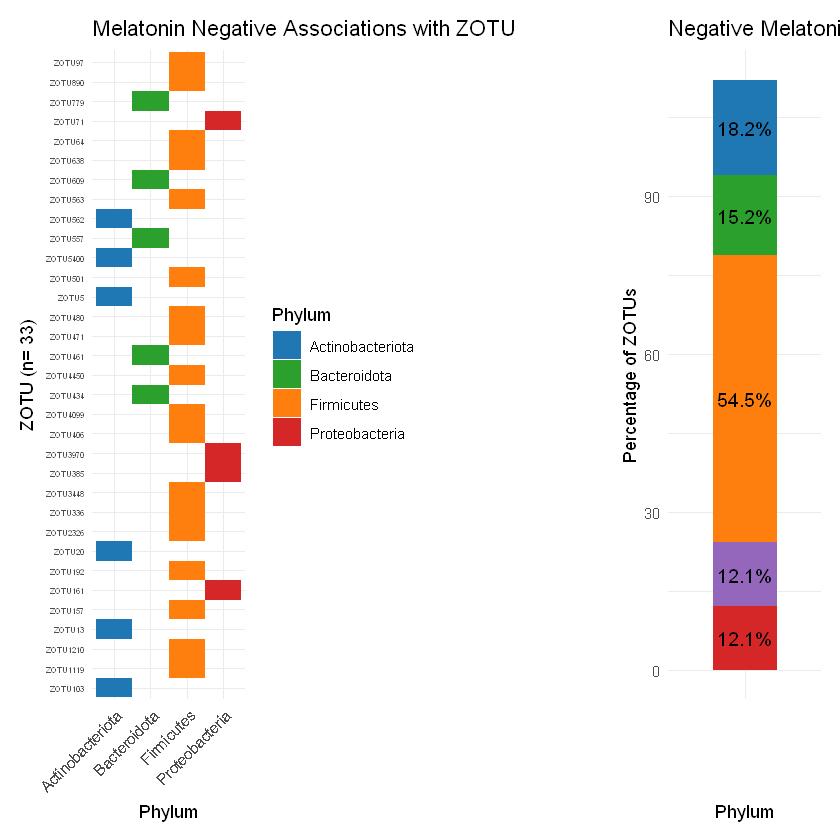

In [13]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(patchwork)

# Assuming ZOTU_phylum is your data frame
# Summarize the data to get the count of ZOTUs per phylum
phylum_summary <- ZOTU_phylum_significance_neg %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Select the top 4 most common phyla and group the rest into "Other"
top_phyla <- phylum_summary %>%
  arrange(desc(ZOTU_count)) %>%
  head(4)

# Combine the rest into "Other"
other_phyla <- phylum_summary %>%
  arrange(desc(ZOTU_count)) %>%
  slice(5:n()) %>%
  summarise(Phylum = "Other", ZOTU_count = sum(ZOTU_count), Percent = sum(Percent))

# Combine the top phyla with "Other"
final_phylum_summary <- bind_rows(top_phyla, other_phyla)

# Assign colors based on Phylum for consistency between plots
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red,
                  "Other" = "#9467bd")             # Purple (for Other if needed)

# Plotting the percentage of ZOTUs in each phylum as a stacked bar chart
phylum_plot <- ggplot(final_phylum_summary, aes(x = "Phyla", y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity", width = 0.5) +  # Use a single bar for all phyla
  scale_fill_manual(values = phyla_colors) +  # Use the consistent color scheme
  geom_text(aes(label = paste0(round(Percent, 1), "%")),  # Add percentage labels
            position = position_stack(vjust = 0.5),       # Place labels in the middle of each segment
            size = 4, color = "black") +                  # Customize label size and color
  labs(title = "Negative Melatonin",
       x = "Phylum",
       y = "Percentage of ZOTUs") +
  theme_minimal() +
  theme(legend.position = "none",
        axis.text.x = element_blank(),  # Remove x-axis text as we only have one bar
        axis.ticks.x = element_blank())  # Remove x-axis ticks

# Plot for significant ZOTUs
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(patchwork)

# Define the four main phyla
main_phyla <- c("Actinobacteriota", "Firmicutes", "Bacteroidota", "Proteobacteria")

# Modify the ZOTU_phylum_significance dataframe to include "Other" for phyla not in the main list
ZOTU_phylum_significance_neg <- ZOTU_phylum_significance_neg %>%
  mutate(Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

# Assign colors based on Phylum for consistency, including "Other"
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red,
                  "Other" = "#9467bd")             # Purple for Other

# Plot for significant ZOTUs with ZOTU names as y-axis labels and color by Phylum
significant_plot <- ggplot(ZOTU_phylum_significance_neg, aes(x = Phylum, y = OTU_ID, fill = Phylum)) +
  geom_tile() +  # Use geom_tile to plot each ZOTU as a tile
  scale_fill_manual(values = phyla_colors) +  # Apply the color scheme based on Phylum
  labs(title = "Melatonin Negative Associations with ZOTU",
       x = "Phylum",
       y = paste0("ZOTU (n= ",zotu_neg, ")") ) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 5, hjust = 1),  # Adjust ZOTU names for readability
        axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for clarity
        legend.position = "right")  # Place the legend on the right for clarity

# Combine the two plots side by side using patchwork
combined_plot_neg<- significant_plot | plot_spacer() | phylum_plot

# Print the combined plot
print(combined_plot_neg)


In [14]:
# Load the devEMF package
library(devEMF)

# Save the combined plot as an .emf file
emf("All_Ages/Neg_Melatonin.emf", width = 7, height = 15)

# Create the plot
print(combined_plot_neg)

# Turn off the emf device
dev.off()


png 
  2

In [15]:
# install.packages("glue") # Uncomment this line if you haven't installed glue yet
library(glue)

Results <- glue(
  "All Melatonin samples: {all_samples}\n",
  "All ZOTUs: {all_zotus}\n",
  "Top ZOTUs used: {max_top_zotus}\n",
  "ZOTUs Positive associated with Melatonin: {zotu_pos}\n",
  "ZOTUs Negative associated with Melatonin: {zotu_neg}"
)


In [16]:
# Save the Results string into a text file
writeLines(Results, "All_Ages/results.txt")
